In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score

## 기대 수명에 영향을 미치는 요인에 대한 회귀 분석
---
6조 고세영 & 김현진
<div>
    <div style="text-align:center";>
    <img src="../imgs/youngandjin_new.gif", style='width=150px; height:530px;'>
    </div>

## CHAPTER 1
---
### Dataset

In [2]:
# Original 결측치 채운 데이터 불러오기
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
original

CountryCode  ISO3166      Country  Year      Status  Life_expectancy  \
0            AFG        4  Afghanistan  2000  Developing             54.8   
1            AFG        4  Afghanistan  2001  Developing             55.3   
2            AFG        4  Afghanistan  2002  Developing             56.2   
3            AFG        4  Afghanistan  2003  Developing             56.7   
4            AFG        4  Afghanistan  2004  Developing             57.0   
...          ...      ...          ...   ...         ...              ...   
2891         ZWE      716     Zimbabwe  2011  Developing             54.9   
2892         ZWE      716     Zimbabwe  2012  Developing             56.6   
2893         ZWE      716     Zimbabwe  2013  Developing             58.0   
2894         ZWE      716     Zimbabwe  2014  Developing             59.2   
2895         ZWE      716     Zimbabwe  2015  Developing             67.0   

      Adult_Mortality  infant_deaths  Alcohol  percentage_expenditure  ...  \
0                 321           90.2     0.01                    0.00  ...   
1                 316           87.6     0.01                    0.00  ...   
2                   3           84.9     0.01                    9.44  ...   
3                 295           82.3     0.01                    8.94  ...   
4                 293           79.6     0.02                    9.81  ...   
...               ...            ...      ...                     ...  ...   
2891              464           51.6     6.00                    8.08  ...   
2892              429           47.9     6.09                    6.92  ...   
2893              399           45.9     6.39                    7.11  ...   
2894              371           44.2     6.50                    8.13  ...   
2895              336           42.9     6.78                    7.45  ...   

      Diphtheria  HIV/AIDS           GDP  Population  thinness_1_19_years  \
0             24       0.1  3.728477e+09    20779953                  2.3   
1             33       0.1  3.876869e+09    21606988                  2.1   
2             36       0.1  4.055180e+09    22600770                 19.9   
3             41       0.1  4.515559e+09    23680871                 19.7   
4              5       0.1  5.226779e+09    24726684                 19.5   
...          ...       ...           ...         ...                  ...   
2891          93      13.3  1.410192e+10     3213972                  6.8   
2892          95       8.8  1.711485e+10     3213972                  6.5   
2893          95       6.8  1.909102e+10     3213972                  6.2   
2894          91       6.3  1.949552e+10     3213972                  5.9   
2895          87       6.2  1.996312e+10     3213972                  5.6   

      thinness_5_9_years  Income_composition_of_resources  Schooling  \
0                    2.5                            0.338        5.5   
1                    2.4                            0.340        5.9   
2                    2.2                            0.341        6.2   
3                   19.9                            0.373        6.5   
4                   19.7                            0.381        6.8   
...                  ...                              ...        ...   
2891                 6.7                            0.452       10.1   
2892                 6.4                            0.464        9.8   
2893                 6.0                            0.488       10.4   
2894                 5.7                            0.498       10.3   
2895                 5.5                            0.507       10.3   

                  Region          IncomeGroup  
0             South Asia           Low income  
1             South Asia           Low income  
2             South Asia           Low income  
3             South Asia           Low income  
4             South Asia           Low income  
...                  ...                  ...  
2891  Sub-Saharan

In [3]:
# 새로운 데이터 및 컬럼 추가 함수
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] for i in range(len(original))]
    
    return original

In [4]:
# GDP per capita 데이터 추가
original = add_feature(original, "gdppercap")
# Nan값 GDP/POP으로 대체
original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)
# 범주형 데이터 처리 - status: Developed, Developing
original = pd.get_dummies(original, columns=['STATUS'])
original.tail()

COUNTRYCODE  ISO3166   COUNTRY  YEAR  LIFE_EXPECTANCY  ADULT_MORTALITY  \
2891         ZWE      716  Zimbabwe  2011             54.9              464   
2892         ZWE      716  Zimbabwe  2012             56.6              429   
2893         ZWE      716  Zimbabwe  2013             58.0              399   
2894         ZWE      716  Zimbabwe  2014             59.2              371   
2895         ZWE      716  Zimbabwe  2015             67.0              336   

      INFANT_DEATHS  ALCOHOL  PERCENTAGE_EXPENDITURE  HEPATITIS_B  ...  \
2891           51.6     6.00                    8.08         94.0  ...   
2892           47.9     6.09                    6.92         97.0  ...   
2893           45.9     6.39                    7.11         95.0  ...   
2894           44.2     6.50                    8.13         91.0  ...   
2895           42.9     6.78                    7.45         87.0  ...   

      POPULATION  THINNESS_1_19_YEARS  THINNESS_5_9_YEARS  \
2891     3213972                  6.8                 6.7   
2892     3213972                  6.5                 6.4   
2893     3213972                  6.2                 6.0   
2894     3213972                  5.9                 5.7   
2895     3213972                  5.6                 5.5   

      INCOME_COMPOSITION_OF_RESOURCES  SCHOOLING              REGION  \
2891                            0.452       10.1  Sub-Saharan Africa   
2892                            0.464        9.8  Sub-Saharan Africa   
2893                            0.488       10.4  Sub-Saharan Africa   
2894                            0.498       10.3  Sub-Saharan Africa   
2895                            0.507       10.3  Sub-Saharan Africa   

              INCOMEGROUP    GDPPERCAP  STATUS_Developed  STATUS_Developing  
2891  Lower middle income  1093.654002                 0                  1  
2892  Lower middle income  1304.969802                 0                  1  
2893  Lower middle income  1430.000818                 0                  1  
2894  Lower middle income  1434.899340                 0                  1  
2895  Lower middle income  1445.071062                 0                  1  

[5 rows x 28 columns]

In [5]:
# 결측치 없이 clean
original.isna().sum()

COUNTRYCODE                        0
ISO3166                            0
COUNTRY                            0
YEAR                               0
LIFE_EXPECTANCY                    0
ADULT_MORTALITY                    0
INFANT_DEATHS                      0
ALCOHOL                            0
PERCENTAGE_EXPENDITURE             0
HEPATITIS_B                        0
MEASLES                            0
BMI                                0
UNDER_FIVE_DEATHS                  0
POLIO                              0
TOTAL_EXPENDITURE                  0
DIPHTHERIA                         0
HIV/AIDS                           0
GDP                                0
POPULATION                         0
THINNESS_1_19_YEARS                0
THINNESS_5_9_YEARS                 0
INCOME_COMPOSITION_OF_RESOURCES    0
SCHOOLING                          0
REGION                             0
INCOMEGROUP                        0
GDPPERCAP                          0
STATUS_Developed                   0
S

## Chapter 2
---
### Outlier processing

In [6]:
# Target에 대한 히스토그램
fig = px.histogram(original, x='LIFE_EXPECTANCY')
fig.update_traces(marker_color='lightslategray')
fig.update_layout(template='plotly_white')

fig.show()

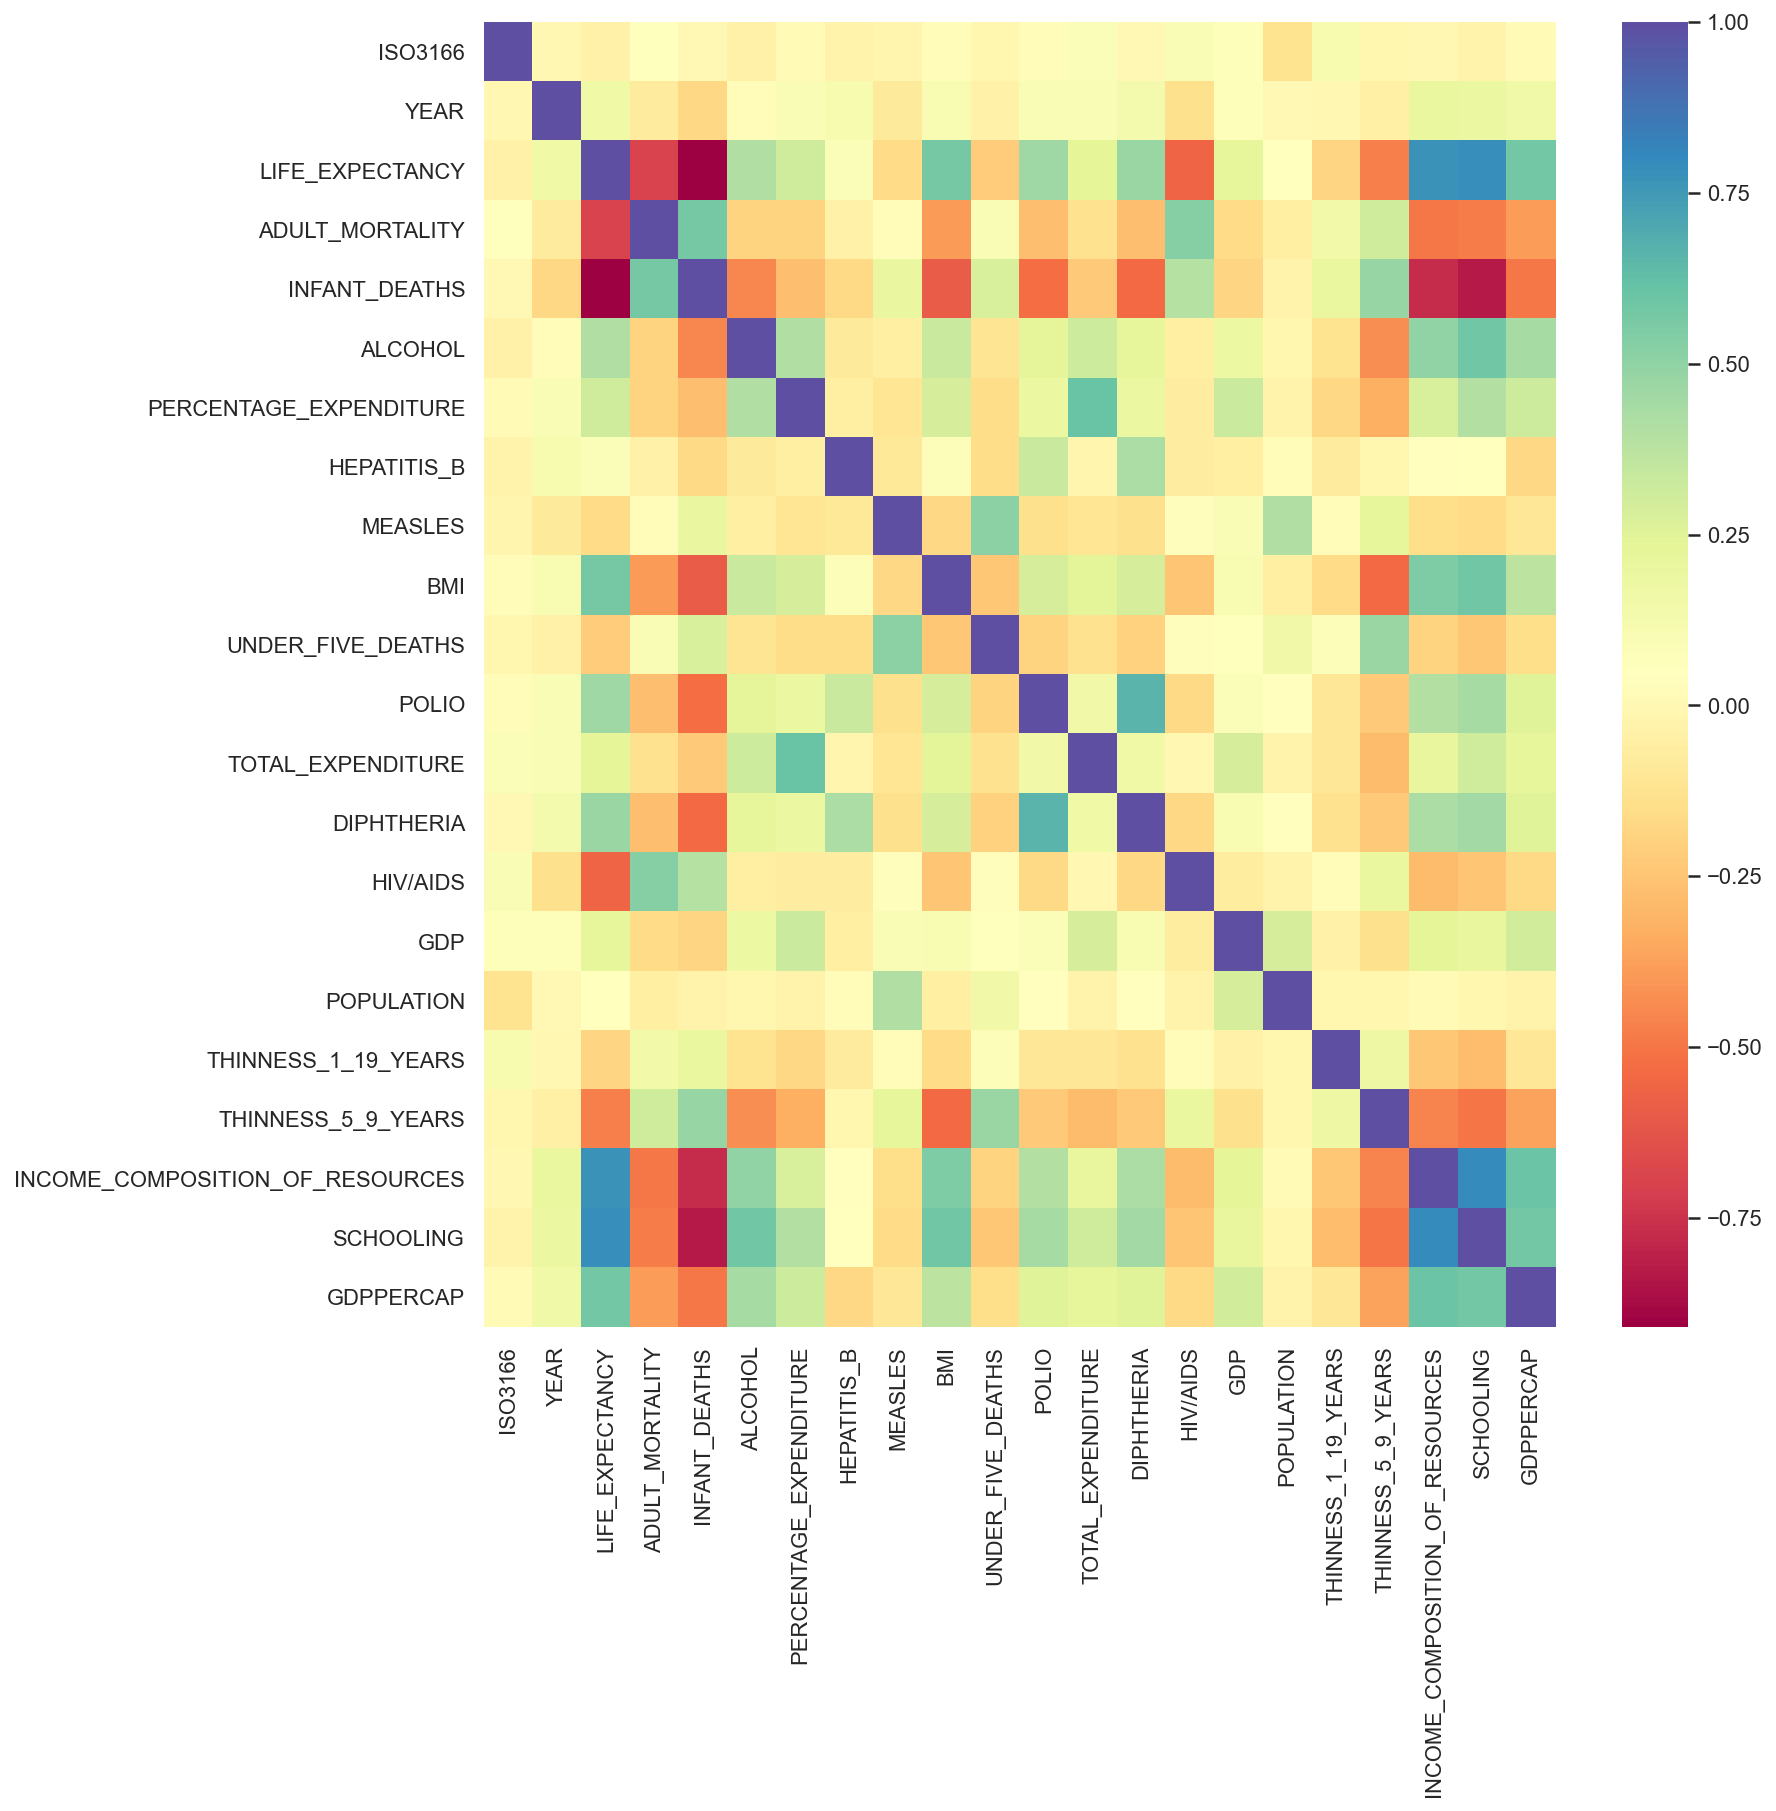

In [28]:
# 히트맵 다시 그리기
plt.figure(figsize=(12,12))

corr= original.corr()
matrix = np.triu(corr)

hmap=sns.heatmap(corr, cmap='Spectral')
hmap.figure.savefig('Correlation_Heatmap_Lower_Triangle_with_Seaborn.png',
                    format='png',annot=True, fmt='.1f', linewidths=0.5, vmax=.3, mask=matrix,
                    dpi=150)

In [8]:
# 기대수명에 대한 나머지 feature들의 상관관계
corr_matrix = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False)

LIFE_EXPECTANCY                    1.000000
SCHOOLING                          0.787959
INCOME_COMPOSITION_OF_RESOURCES    0.770265
GDPPERCAP                          0.579974
BMI                                0.569823
STATUS_Developed                   0.482296
DIPHTHERIA                         0.476862
POLIO                              0.460203
ALCOHOL                            0.403884
PERCENTAGE_EXPENDITURE             0.307408
TOTAL_EXPENDITURE                  0.232089
GDP                                0.220116
HEPATITIS_B                        0.086449
POPULATION                         0.046521
MEASLES                           -0.156640
THINNESS_1_19_YEARS               -0.185859
UNDER_FIVE_DEATHS                 -0.222133
THINNESS_5_9_YEARS                -0.473572
STATUS_Developing                 -0.482296
HIV/AIDS                          -0.562928
ADULT_MORTALITY                   -0.694259
INFANT_DEATHS                     -0.909425
Name: LIFE_EXPECTANCY, dtype: fl

In [9]:
# 절댓값을 적용한 상관관계가 높은 특징 top 6
# infant_datehs > schooling > income_composition_of_resources > adult_mortality
top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[1:7]
top_features = top_corr.index.tolist()
top_corr 

INFANT_DEATHS                      0.909425
SCHOOLING                          0.787959
INCOME_COMPOSITION_OF_RESOURCES    0.770265
ADULT_MORTALITY                    0.694259
GDPPERCAP                          0.579974
BMI                                0.569823
Name: LIFE_EXPECTANCY, dtype: float64

In [10]:
top_features

['INFANT_DEATHS',
 'SCHOOLING',
 'INCOME_COMPOSITION_OF_RESOURCES',
 'ADULT_MORTALITY',
 'GDPPERCAP',
 'BMI']

In [11]:
# 상위 5개 feature에 대한 리전별 boxplot
from sklearn import preprocessing

fig = go.Figure()

for i in range(len(top_features)):
    fig.add_trace(go.Box(x=original['REGION'], y=preprocessing.minmax_scale(original[top_features[i]]), notched=True,
                        name=top_features[i]))

fig.update_layout(boxmode='group', xaxis_tickangle=0, width=1700, height=800, template='plotly_white')
    
fig.show()

In [12]:
def show_boxplot(color, y_idx):
    fig = go.Figure()
    
    fig.add_trace(go.Box(
            x=original['REGION'], y=original[top_features[y_idx]], name=top_features[y_idx],
            boxpoints='all', jitter=0.2, whiskerwidth=0.2, marker_color=color, marker_size=2,
            line_width=2))
    
    fig.update_layout(boxmode='group', xaxis=dict(title=top_features[y_idx], zeroline=False), 
                      xaxis_tickangle=0, width=1300, height=500, template='plotly_white')
     
    fig.show()
    
colors = ['#3D9970', '#FF4136', '#FF851B','#3D9970', '#FF4136', '#FF851B']

for idx, feature in enumerate(top_features[:6]):
    show_boxplot(colors[idx], idx)

In [13]:
# lower fence, upper fence
region = original['REGION'].unique().tolist()
fence = {}

for r in region:
    fence[r] = {}
    
    for i, f in enumerate(top_features):
        q1 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 25)
        q3 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 75)
        iqr = q3 - q1

        upper_fence = ((iqr * 1.5) + q3).round(3)
        lower_fence = (q1 - (iqr * 1.5)).round(3)
                
        fence[r][f] = [lower_fence, upper_fence]
fence

{'South Asia': {'INFANT_DEATHS': [-19.787, 108.912],
  'SCHOOLING': [2.688, 17.588],
  'INCOME_COMPOSITION_OF_RESOURCES': [0.262, 0.802],
  'ADULT_MORTALITY': [7.125, 346.125],
  'GDPPERCAP': [-1298.544, 3615.431],
  'BMI': [6.85, 25.85]},
 'Sub-Saharan Africa': {'INFANT_DEATHS': [-3.85, 129.55],
  'SCHOOLING': [2.2, 15.8],
  'INCOME_COMPOSITION_OF_RESOURCES': [0.213, 0.696],
  'ADULT_MORTALITY': [-79.125, 647.875],
  'GDPPERCAP': [-1531.768, 3716.907],
  'BMI': [3.9, 37.5]},
 'Europe & Central Asia': {'INFANT_DEATHS': [-9.075, 24.725],
  'SCHOOLING': [9.1, 20.3],
  'INCOME_COMPOSITION_OF_RESOURCES': [0.512, 1.089],
  'ADULT_MORTALITY': [-71.0, 289.0],
  'GDPPERCAP': [-41822.476, 80406.403],
  'BMI': [39.488, 70.387]},
 'Middle East & North Africa': {'INFANT_DEATHS': [-15.475, 49.525],
  'SCHOOLING': [7.4, 18.0],
  'INCOME_COMPOSITION_OF_RESOURCES': [0.41, 1.029],
  'ADULT_MORTALITY': [-48.0, 250.0],
  'GDPPERCAP': [-24337.91, 47645.12],
  'BMI': [26.075, 84.075]},
 'Latin America & Ca

In [14]:
# 이상치 제거
region = original['REGION'].unique().tolist()
drop_list, target_idx = [], []

for r in region:
    target_df = original[original['REGION'] == r]
    
    for f in top_features:
        drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                  (target_df[f] > fence[r][f][1])].index.tolist()
        
        drop_list.append(drop_idx)

# 제거 대상 인덱스
target_idx = set([idx for lst in drop_list for idx in lst])
original = original.drop(target_idx, axis=0)

In [15]:
# 주요 feature regression plot
target = original['LIFE_EXPECTANCY']
fig = make_subplots(rows=3, cols=2, subplot_titles=top_features)
count = 0

for i in range(3):
    for j in range(2):
        regline = sm.OLS(target, sm.add_constant(original[top_features[count]])).fit().fittedvalues

        fig.add_traces(go.Scatter(x=original[top_features[count]], 
                                  y=target, mode='markers', name=top_features[count]),
                               rows=i+1, cols=j+1)

        fig.add_traces(go.Scatter(x=original[top_features[count]], 
                                  y=regline, mode='lines',
                                  showlegend=False), 
                       rows=i+1, cols=j+1)

        count += 1
        
fig.update_layout(width=1800, height=800, template='plotly_white')

fig.show()

## Chapter 3
---
### Modeling

In [16]:
# x, y 구분 함수
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def original_sortion_xy(original):
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    if 'STATUS' in original.columns.tolist():
        original = pd.get_dummies(original, columns=['STATUS'])   
    
    X = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP'], axis=1)
    y = original['LIFE_EXPECTANCY']
    
    return X, y

In [17]:
# Linear regression fit 함수
def fit_datas(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X_train, y_train)
    
    pred_test = model.predict(X_test)
    predictions = [round(value) for value in pred_test]
    
    # evaluate predictions
    accuracy = model.score(X_test, y_test)
    
    print("Accuracy score:", accuracy)
    print('RMSE : ', np.sqrt(accuracy).mean())
    
    return X_train, X_test, y_train, y_test

### 1. Linear Regression

#### 1-1. Linear Regression original
- Accuracy 91.7%
- RMSE 0.96

In [18]:
#Linear Regression
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
X, y = original_sortion_xy(original)

X_train, X_test, y_train, y_test = fit_datas(X, y)

lm = sm.OLS(y_test, X_test).fit()
lm.summary()

Accuracy score: 0.9171052313833589
RMSE :  0.9576561133221877


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     337.6
Date:                Thu, 13 May 2021   Prob (F-statistic):          6.03e-292
Time:                        00:57:23   Log-Likelihood:                -1394.7
No. Observations:                 580   AIC:                             2829.
Df Residuals:                     560   BIC:                             2917.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
ADULT_MORTALITY                    -0.0102      0.001     -7.521      0.000      -0.013      -0.008
INFANT_DEATHS                      -0.2188      0.009    -24.064      0.000      -0.237      -0.201
ALCOHOL                            -0.1462      0.041     -3.570      0.000      -0.227      -0.066
PERCENTAGE_EXPENDITURE              0.1320      0.057      2.306      0.021       0.020       0.244
HEPATITIS_B                        -0.0142      0.004     -3.194      0.001      -0.023      -0.005
MEASLES                         -8.574e-07   1.06e-05     -0.081      0.936   -2.18e-05       2e-05
BMI                                -0.0052      0.008     -0.621      0.535      -0.022       0.011
UNDER_FIVE_DEATHS                   0.0003      0.001      0.273      0.785      -0.002       0.002
POLIO                              -0.0027      0.006     -0.419      0.675      -0.015       0.010
TOTAL_EXPENDITURE                   0.0286      0.055      0.518      0.605      -0.080       0.137
DIPHTHERIA                          0.0132      0.007      1.923      0.055      -0.000       0.027
HIV/AIDS                           -0.3787      0.030    -12.662      0.000      -0.437      -0.320
GDP                              2.019e-13   1.15e-13      1.749      0.081   -2.48e-14    4.29e-13
POPULATION                       7.221e-10   1.43e-09      0.504      0.614   -2.09e-09    3.54e-09
THINNESS_1_19_YEARS                -0.0004      0.003     -0.116      0.908      -0.007       0.006
THINNESS_5_9_YEARS                  0.0015      0.036      0.042      0.966      -0.069       0.072
INCOME_COMPOSITION_OF_RESOURCES     3.5402      0.979      3.618      0.000       1.618       5.462
SCHOOLING                           0.2029      0.081      2.504      0.013       0.044       0.362
STATUS_Developed                   74.8313      1.440     51.972      0.000      72.003      77.659
STATUS_Developing                  73.3227      1.338     54.792      0.000      70.694      75.951
==============================================================================
Omnibus:                       44.377   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.533
Skew:                           0.456   Prob(JB):                     1.33e-20
Kurtosis:                       4.719   Cond. No.                     2.05e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 1-2. Linear Regression: Feature selection
- Drop Features: 'Schooling', 'GDP'
- Add Feature: 'GDP per Capita'
- Accuracy 92.0% (Original 대비 +0.3%)
- RMSE 0.96

In [19]:
# x, y 구분 + DROP (Schooling, GDP) + ADD(GDP per Capita) 
def sortion_xy(original):
    original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
    original = add_feature(original, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)
    if 'STATUS' in original.columns.tolist():
        original = pd.get_dummies(original, columns=['STATUS'])   
    
    X = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP', "SCHOOLING", "GDP"], axis=1)
    y = original['LIFE_EXPECTANCY']
    
    return X, y

In [20]:
#Linear Regression 함수 fit_datas(X, y)
X, y = sortion_xy(original)

X_train, X_test, y_train, y_test = fit_datas(X, y)

lm = sm.OLS(y_test, X_test).fit()
lm.summary()

Accuracy score: 0.9201200152863409
RMSE :  0.9592288649151155


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     370.4
Date:                Thu, 13 May 2021   Prob (F-statistic):          2.46e-297
Time:                        00:57:23   Log-Likelihood:                -1384.9
No. Observations:                 580   AIC:                             2808.
Df Residuals:                     561   BIC:                             2891.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
ADULT_MORTALITY                    -0.0097      0.001     -7.197      0.000      -0.012      -0.007
INFANT_DEATHS                      -0.2284      0.008    -29.215      0.000      -0.244      -0.213
ALCOHOL                            -0.1184      0.039     -3.050      0.002      -0.195      -0.042
PERCENTAGE_EXPENDITURE              0.1424      0.055      2.590      0.010       0.034       0.250
HEPATITIS_B                        -0.0099      0.004     -2.218      0.027      -0.019      -0.001
MEASLES                          -8.04e-07   1.04e-05     -0.077      0.939   -2.13e-05    1.97e-05
BMI                                -0.0020      0.008     -0.242      0.809      -0.018       0.014
UNDER_FIVE_DEATHS                   0.0004      0.001      0.446      0.656      -0.001       0.002
POLIO                              -0.0038      0.006     -0.616      0.538      -0.016       0.008
TOTAL_EXPENDITURE                   0.0540      0.054      1.001      0.317      -0.052       0.160
DIPHTHERIA                          0.0117      0.007      1.731      0.084      -0.002       0.025
HIV/AIDS                           -0.3806      0.029    -12.996      0.000      -0.438      -0.323
POPULATION                       1.568e-09   1.34e-09      1.171      0.242   -1.06e-09     4.2e-09
THINNESS_1_19_YEARS                -0.0022      0.003     -0.727      0.468      -0.008       0.004
THINNESS_5_9_YEARS                  0.0129      0.035      0.364      0.716      -0.057       0.082
INCOME_COMPOSITION_OF_RESOURCES     3.2836      0.939      3.496      0.001       1.439       5.129
GDPPERCAP                        5.005e-05   9.37e-06      5.343      0.000    3.16e-05    6.84e-05
STATUS_Developed                   76.0598      1.162     65.436      0.000      73.777      78.343
STATUS_Developing                  75.1329      1.052     71.420      0.000      73.067      77.199
==============================================================================
Omnibus:                       43.521   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.193
Skew:                           0.461   Prob(JB):                     1.92e-19
Kurtosis:                       4.648   Cond. No.                     1.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 1-3. Linear Regression: Feature Extraction
- PCA 차원축소

In [43]:
# 상관계수가 높은 4개의 피처에 대한 아웃라이어 제거까지 전처리
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] 
                              for i in range(len(original))]
    return original

# GDP per capita 데이터 추가
original = add_feature(original, "gdppercap")

# Nan값 GDP/POP으로 대체
original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)
original.columns = [cols.upper() for cols in original.columns.tolist()]


# 기대수명에 대한 나머지 feature들의 상관관계
corr_matrix = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False)

# LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[:5]
top_features = top_corr.index.tolist()

# lower fence, upper fence
region = original['REGION'].unique().tolist()
fence = {}

for r in region:
    fence[r] = {}
    
    for i, f in enumerate(top_features):
        q1 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 25)
        q3 = np.percentile(original[original['REGION'] == r][top_features[i]].values, 75)
        iqr = q3 - q1

        upper_fence = ((iqr * 1.5) + q3).round(3)
        lower_fence = (q1 - (iqr * 1.5)).round(3)
                
        fence[r][f] = [lower_fence, upper_fence]
   
    
# 이상치 제거
region = original['REGION'].unique().tolist()
drop_list, target_idx = [], []

for r in region:
    target_df = original[original['REGION'] == r]
    
    for f in top_features:
        drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                  (target_df[f] > fence[r][f][1])].index.tolist()
        
        drop_list.append(drop_idx)

# 제거 대상 인덱스
target_idx = set([idx for lst in drop_list for idx in lst])
original = original.drop(target_idx, axis=0)

In [44]:
# 리전별 인덱스로 바꾸고 biplot을 다시 그려본다.
original = original.groupby('REGION').mean().round(3)

# 아웃라이어가 제거된 데이터로 PCA
# 단위 차이를 줄이기 위해 스케일링 적용
target = original['LIFE_EXPECTANCY']
original = original.drop(['ISO3166', 'YEAR', 'LIFE_EXPECTANCY'], axis=1)
original_ss = StandardScaler().fit_transform(original)

ss_df = pd.DataFrame(original_ss, index=original.index, columns=original.columns)

# # 모든 독립변수 개수만큼 주성분 개수를 설정한다. - 리전을 인덱스로 하면 
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca_res = pca.fit_transform(ss_df)

# 각 주성분 값을 데이터로 하는 데이터프레임을 생성한다. 
pca_df = pd.DataFrame(pca_res, index=ss_df.index, 
                      columns=[f"pca{num+1}" for num in range(7)])
pca_df.head()

pca1      pca2      pca3      pca4      pca5  \
REGION                                                                         
East Asia & Pacific        -1.104715 -1.124461  0.860038  2.301477  0.088701   
Europe & Central Asia       3.178904 -0.394485 -0.645716 -0.545476  1.357003   
Latin America & Caribbean   0.932119 -1.127201 -1.200440  0.003801  0.165525   
Middle East & North Africa  0.816986 -2.615928 -0.643156 -0.763652 -1.112366   
North America               5.249219  2.857073  1.067372  0.077632 -0.598388   

                                pca6          pca7  
REGION                                              
East Asia & Pacific        -0.154721  3.578837e-16  
Europe & Central Asia      -0.400644  3.578837e-16  
Latin America & Caribbean   0.887689  3.578837e-16  
Middle East & North Africa -0.352023  3.578837e-16  
North America               0.056697  3.578837e-16

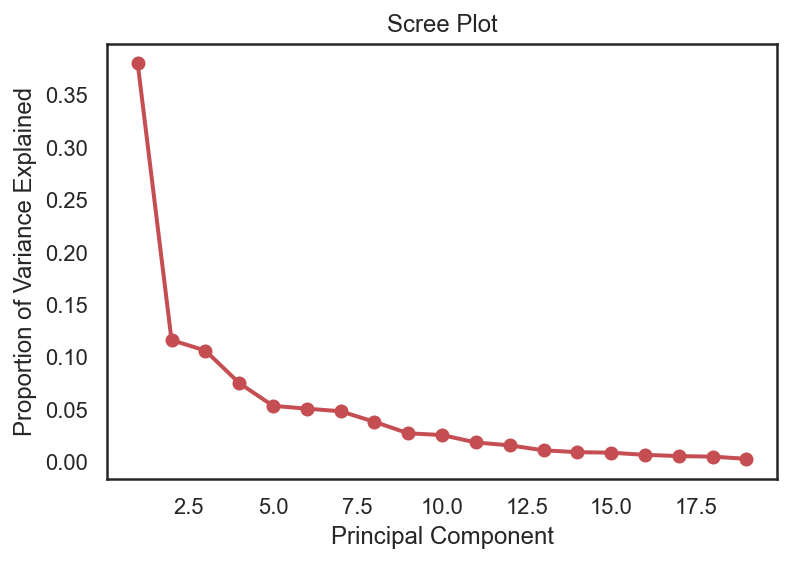

In [37]:
# Scree Plot을 이용해 적절한 주성분 개수를 알아본다.
# 라인이 갑자기 크게 완만해지는 지점이 적절한 주성분 개수가 된다.
PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component') # 주성분 개수
plt.ylabel('Proportion of Variance Explained') # 고유값 (분산 값)

plt.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


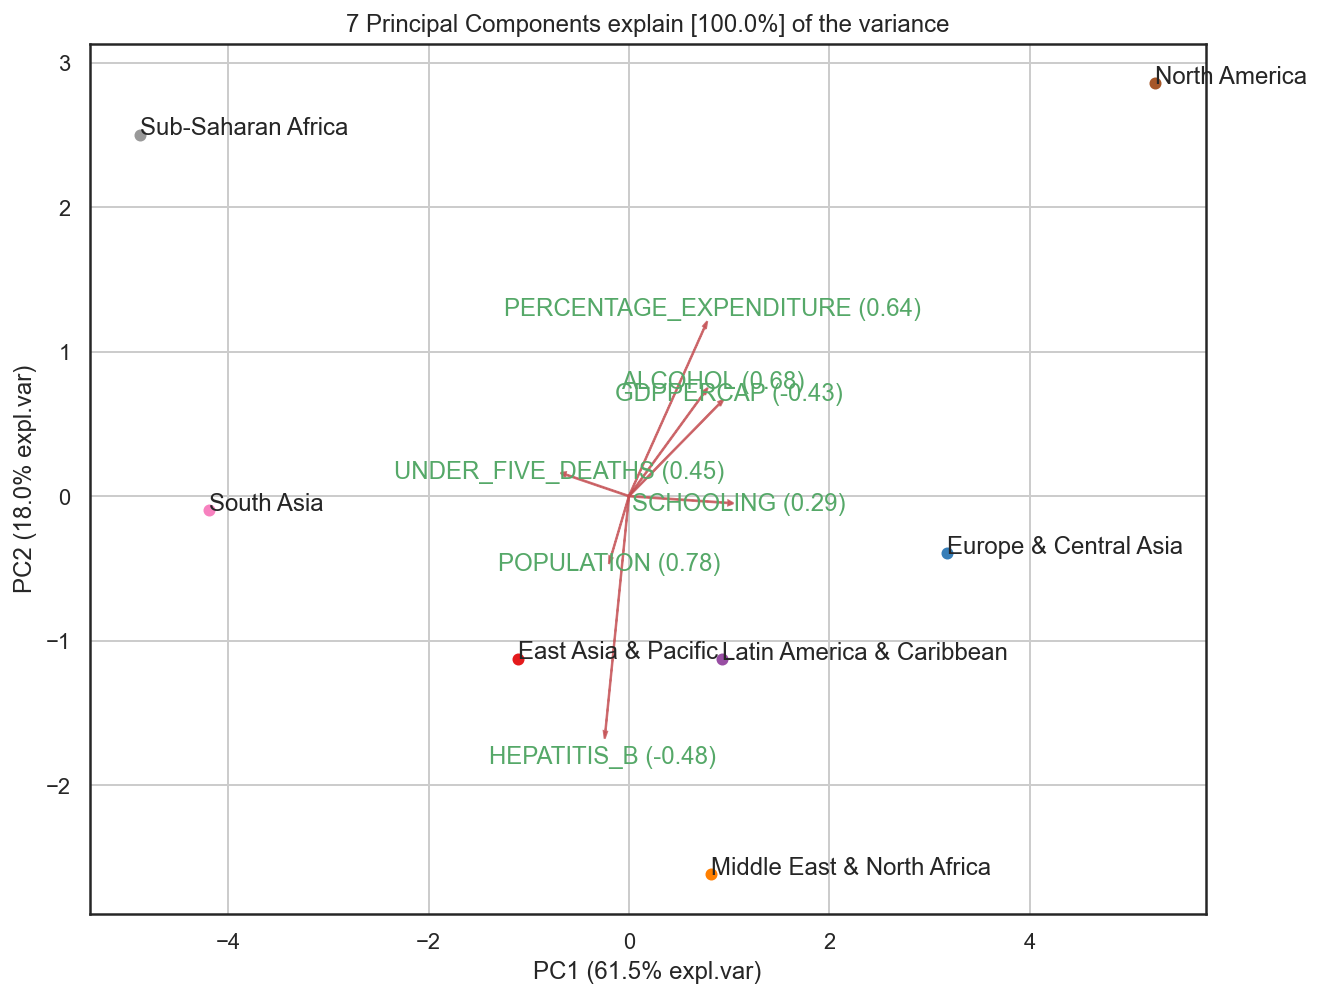

In [45]:
# n개의 특성으로 정리
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca.fit(original_ss)
pca_res = pca.transform(original_ss)

pca_cols = [f"pca{num+1}" for num in range(7)]
originss_pca_df = pd.DataFrame(pca_res, columns=pca_cols)
originss_pca_df['target'] = target

# n개의 특성으로 정리한 biplot
pca = PCA(n_components=7)
pca.fit(original_ss)
pca_res = pca.transform(original_ss)

# 빨간선은 변수
from sklearn.decomposition import PCA
from pca import pca # biplot을 그리기 위한 별도 라이브러리

pca_df = pd.DataFrame(pca_res, index=ss_df.index,
                      columns=pca_cols)
                      
model = pca(n_components=7)
results = model.fit_transform(ss_df)
fig, ax = model.biplot(n_feat=7, legend=False)

<img src='../imgs/pca_2.png'/>

#### 1-4. Linear Regression Scaling
- Accuracy 92.0% (변화없음)

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# X에 스케일러들을 적용해보니, accuracy는 적용 전후가 똑같고, 
# coef, std err 수치가 좀 깔끔하게 나오는 차이가 있다
X, y = sortion_xy(original)

mm = MinMaxScaler()
X_mm = mm.fit_transform(X)

X_train, X_test, y_train, y_test = fit_datas(X_mm, y)
 
lm = sm.OLS(y_test, X_test).fit()
lm.summary()

Accuracy score: 0.9201200152863409
RMSE :  0.9592288649151155


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     370.4
Date:                Thu, 13 May 2021   Prob (F-statistic):          2.46e-297
Time:                        00:57:24   Log-Likelihood:                -1384.9
No. Observations:                 580   AIC:                             2808.
Df Residuals:                     561   BIC:                             2891.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -6.9820      0.970     -7.197      0.000      -8.888      -5.076
x2           -31.4492      1.076    -29.215      0.000     -33.564     -29.335
x3            -2.1152      0.694     -3.050      0.002      -3.477      -0.753
x4             2.9063      1.122      2.590      0.010       0.702       5.110
x5            -0.9790      0.441     -2.218      0.027      -1.846      -0.112
x6            -0.1706      2.217     -0.077      0.939      -4.525       4.184
x7            -0.1512      0.625     -0.242      0.809      -1.379       1.076
x8             1.0046      2.253      0.446      0.656      -3.421       5.430
x9            -0.3667      0.596     -0.616      0.538      -1.536       0.803
x10            0.9296      0.929      1.001      0.317      -0.895       2.754
x11            1.1361      0.656      1.731      0.084      -0.153       2.426
x12          -19.2200      1.479    -12.996      0.000     -22.125     -16.315
x13            2.1499      1.836      1.171      0.242      -1.456       5.756
x14           -0.8212      1.130     -0.727      0.468      -3.040       1.398
x15            0.3672      1.010      0.364      0.716      -1.616       2.350
x16            3.1129      0.890      3.496      0.001       1.364       4.862
x17            7.5199      1.407      5.343      0.000       4.755      10.284
x18           75.6321      1.141     66.281      0.000      73.391      77.873
x19           74.7052      1.030     72.564      0.000      72.683      76.727
==============================================================================
Omnibus:                       43.521   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.193
Skew:                           0.461   Prob(JB):                     1.92e-19
Kurtosis:                       4.648   Cond. No.                         47.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2. Decision Tree Regressor
- Accuracy 94.2% (Linear Regression 대비 +2.2%p)
- RMSE 0.97

In [22]:
# DecisionTreeRegressor를 쓰니까 정확도가 94.2%
from sklearn.tree import DecisionTreeRegressor

X, y = sortion_xy(original)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
print("Decision Tree Regressor Accuracy:", model.score(X_test, y_test))
print('RMSE Mean : ', np.sqrt(model.score(X_test, y_test)).mean())
lm = sm.OLS(y_test, X_test).fit()
lm.summary()

Decision Tree Regressor Accuracy: 0.9444434560665116
RMSE Mean :  0.9718248072911658


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     370.4
Date:                Thu, 13 May 2021   Prob (F-statistic):          2.46e-297
Time:                        00:57:24   Log-Likelihood:                -1384.9
No. Observations:                 580   AIC:                             2808.
Df Residuals:                     561   BIC:                             2891.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
ADULT_MORTALITY                    -0.0097      0.001     -7.197      0.000      -0.012      -0.007
INFANT_DEATHS                      -0.2284      0.008    -29.215      0.000      -0.244      -0.213
ALCOHOL                            -0.1184      0.039     -3.050      0.002      -0.195      -0.042
PERCENTAGE_EXPENDITURE              0.1424      0.055      2.590      0.010       0.034       0.250
HEPATITIS_B                        -0.0099      0.004     -2.218      0.027      -0.019      -0.001
MEASLES                          -8.04e-07   1.04e-05     -0.077      0.939   -2.13e-05    1.97e-05
BMI                                -0.0020      0.008     -0.242      0.809      -0.018       0.014
UNDER_FIVE_DEATHS                   0.0004      0.001      0.446      0.656      -0.001       0.002
POLIO                              -0.0038      0.006     -0.616      0.538      -0.016       0.008
TOTAL_EXPENDITURE                   0.0540      0.054      1.001      0.317      -0.052       0.160
DIPHTHERIA                          0.0117      0.007      1.731      0.084      -0.002       0.025
HIV/AIDS                           -0.3806      0.029    -12.996      0.000      -0.438      -0.323
POPULATION                       1.568e-09   1.34e-09      1.171      0.242   -1.06e-09     4.2e-09
THINNESS_1_19_YEARS                -0.0022      0.003     -0.727      0.468      -0.008       0.004
THINNESS_5_9_YEARS                  0.0129      0.035      0.364      0.716      -0.057       0.082
INCOME_COMPOSITION_OF_RESOURCES     3.2836      0.939      3.496      0.001       1.439       5.129
GDPPERCAP                        5.005e-05   9.37e-06      5.343      0.000    3.16e-05    6.84e-05
STATUS_Developed                   76.0598      1.162     65.436      0.000      73.777      78.343
STATUS_Developing                  75.1329      1.052     71.420      0.000      73.067      77.199
==============================================================================
Omnibus:                       43.521   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.193
Skew:                           0.461   Prob(JB):                     1.92e-19
Kurtosis:                       4.648   Cond. No.                     1.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 3. XGBoost Regressor
- Accuracy 96.8% (Linear Regression 대비 +4.8%p)
- cross validation mean: 96.6%
- RMSE 0.98

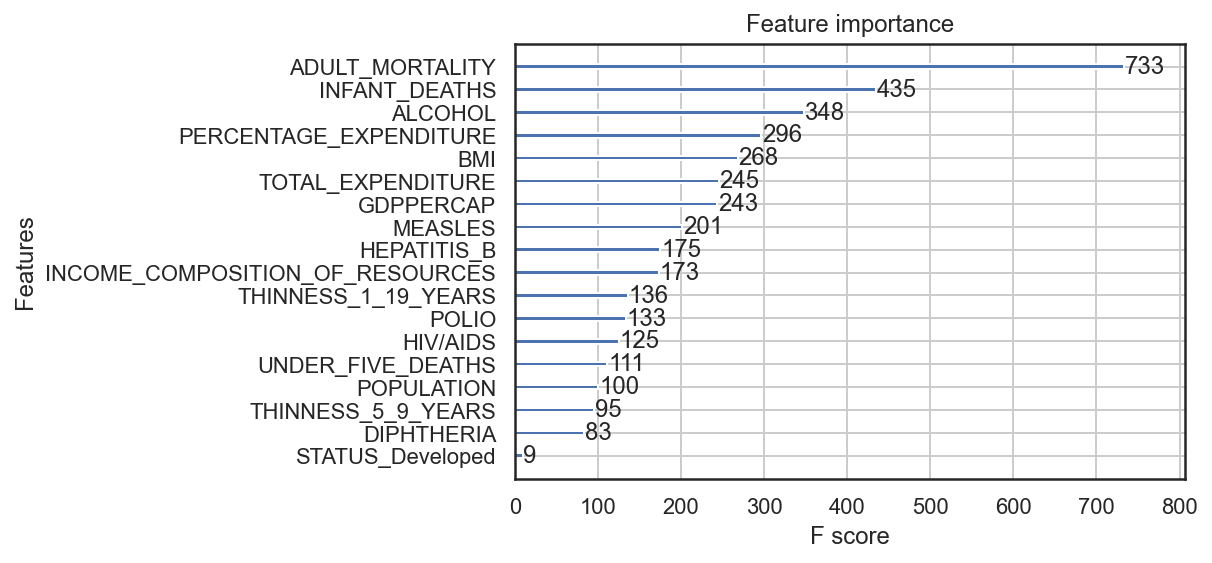

In [23]:
# XGBoost regressor로 해보니 96.8%
# plot importance로 model에서 중요도 높은(f score 높은) feature 그래프화
from xgboost import XGBRegressor
from xgboost import plot_importance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

model = XGBRegressor()
model.fit(X_train, y_train, eval_metric="error", verbose=True)

plot_importance(model)
plt.show()

In [24]:
pred_test = model.predict(X_test)
predictions = [round(value) for value in pred_test]

# evaluate predictions
accuracy = model.score(X_test, y_test)
print("Accuracy score:", accuracy)
print('RMSE score : ', np.sqrt(accuracy))

Accuracy score: 0.9682190556658504
RMSE score :  0.9839812272934125


In [25]:
# cross validation을 해보니 평균 96.7%
from sklearn.model_selection import cross_val_score, KFold

X, y = sortion_xy(original)
kfold = KFold(n_splits=5, shuffle=True,random_state=13)
model = XGBRegressor()

accuracy = cross_val_score(model, X, y, cv=kfold)
print('Cross Validation : ', accuracy)
print('Cross Validation Mean :', accuracy.mean())
print('Cross Validation std :', accuracy.std())
print('RMSE score : ', np.sqrt(accuracy))
print('RMSE Mean : ', np.sqrt(accuracy).mean())
print('RMSE std : ', np.sqrt(accuracy).std())

Cross Validation :  [0.96821906 0.96534593 0.96392192 0.97111927 0.96403901]
Cross Validation Mean : 0.9665290373841628
Cross Validation std : 0.002768518367643691
RMSE score :  [0.98398123 0.98252019 0.98179526 0.98545384 0.98185488]
RMSE Mean :  0.9831210793340489
RMSE std :  0.0014073923466779157


#### 4. Random Forest Regressor
- Accuracy 97.3% (Linear Regression 대비 +5.3%p)
- cross validation mean: 97.0%
- RMSE 0.99

In [26]:
# RandomForestRegressor를 쓰니까 정확도가 97.3%
from sklearn.ensemble import RandomForestRegressor
original = add_feature(original, filename="gdppercap")
original["GDPPERCAP"].fillna(original["GDP"]/original["POPULATION"], inplace=True)

X, y = sortion_xy(original)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
model = RandomForestRegressor()
model.fit(X_train, y_train)
print("Random Forest Regressor Accuracy:", model.score(X_test, y_test))
print('Random Forest Regressor RMSE : ', np.sqrt(model.score(X_test, y_test)).mean())

lm = sm.OLS(y_test, X_test).fit()
lm.summary()

Random Forest Regressor Accuracy: 0.9722954097061426
Random Forest Regressor RMSE :  0.9860504093129026


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     370.4
Date:                Thu, 13 May 2021   Prob (F-statistic):          2.46e-297
Time:                        00:57:30   Log-Likelihood:                -1384.9
No. Observations:                 580   AIC:                             2808.
Df Residuals:                     561   BIC:                             2891.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
ADULT_MORTALITY                    -0.0097      0.001     -7.197      0.000      -0.012      -0.007
INFANT_DEATHS                      -0.2284      0.008    -29.215      0.000      -0.244      -0.213
ALCOHOL                            -0.1184      0.039     -3.050      0.002      -0.195      -0.042
PERCENTAGE_EXPENDITURE              0.1424      0.055      2.590      0.010       0.034       0.250
HEPATITIS_B                        -0.0099      0.004     -2.218      0.027      -0.019      -0.001
MEASLES                          -8.04e-07   1.04e-05     -0.077      0.939   -2.13e-05    1.97e-05
BMI                                -0.0020      0.008     -0.242      0.809      -0.018       0.014
UNDER_FIVE_DEATHS                   0.0004      0.001      0.446      0.656      -0.001       0.002
POLIO                              -0.0038      0.006     -0.616      0.538      -0.016       0.008
TOTAL_EXPENDITURE                   0.0540      0.054      1.001      0.317      -0.052       0.160
DIPHTHERIA                          0.0117      0.007      1.731      0.084      -0.002       0.025
HIV/AIDS                           -0.3806      0.029    -12.996      0.000      -0.438      -0.323
POPULATION                       1.568e-09   1.34e-09      1.171      0.242   -1.06e-09     4.2e-09
THINNESS_1_19_YEARS                -0.0022      0.003     -0.727      0.468      -0.008       0.004
THINNESS_5_9_YEARS                  0.0129      0.035      0.364      0.716      -0.057       0.082
INCOME_COMPOSITION_OF_RESOURCES     3.2836      0.939      3.496      0.001       1.439       5.129
GDPPERCAP                        5.005e-05   9.37e-06      5.343      0.000    3.16e-05    6.84e-05
STATUS_Developed                   76.0598      1.162     65.436      0.000      73.777      78.343
STATUS_Developing                  75.1329      1.052     71.420      0.000      73.067      77.199
==============================================================================
Omnibus:                       43.521   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.193
Skew:                           0.461   Prob(JB):                     1.92e-19
Kurtosis:                       4.648   Cond. No.                     1.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# cross validation을 해보니 평균 97.1%
from sklearn.model_selection import cross_val_score, KFold

X, y = sortion_xy(original)
kfold = KFold(n_splits=5, shuffle=True,random_state=13)
model = RandomForestRegressor()

accuracy = cross_val_score(model, X, y, cv=kfold)
print('Cross Validation : ', accuracy)
print('Cross Validation Mean :', accuracy.mean())
print('Cross Validation std :', accuracy.std())
print('RMSE score : ', np.sqrt(accuracy))
print('RMSE Mean : ', np.sqrt(accuracy).mean())
print('RMSE std : ', np.sqrt(accuracy).std())

Cross Validation :  [0.97324337 0.96919337 0.96506071 0.97386637 0.96971295]
Cross Validation Mean : 0.9702153518223223
Cross Validation std : 0.003173831074258919
RMSE score :  [0.98653098 0.98447619 0.98237503 0.98684668 0.98474004]
RMSE Mean :  0.9849937840199277
RMSE std :  0.0016116030610985527


## To do
---
1. EDA Visualization 추가
2. PCA
3. Model별 feature selection을 통한 비교
4. .py 파일로 모듈화 작업